In [1]:
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [3]:
from ase import io
from ase.visualize import view
from ase.build import sort, molecule

In [28]:
from helpers import validate
from helpers import read_metrics

In [13]:
from pyace import PyACECalculator

In [14]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 18
# mpl.rcParams['font.family'] = 'Times'

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 3.
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.top']=True

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 3.
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.right']=True

In [9]:
import os
import warnings
def read_log(path):
    os.system(f'cat {path}/lmp.out | grep -e Step -e Loop -n > read_log')
    file = open('read_log').readlines()
#     os.system('rm read_log')
    log_lst = list()
    for i in range(0,len(file),2):
        try:
                n1 = int(file[i].replace(':',' ').split()[0])
                n2 = int(file[i+1].replace(':',' ').split()[0])
                log_lst.append(pd.read_csv(f'{path}/lmp.out',
                                   skiprows=n1-1, nrows=n2-n1-1, sep= '\s+'))
        except:
            break

    if(len(file)%2 ==0):
        return log_lst
    else:
        warnings.warn('Last run is not finished')            
        n = int(file[-1].replace(':',' ').split()[0])
        log_lst.append(pd.read_csv(f'{path}/lmp.out', skiprows=n-1, sep= '\s+'))

    return log_lst

In [10]:
def write_lmp_file_eq(T, P, path):
    s= np.random.randint(99999)
    lines= ['\n',
 'units\t\tmetal\t\t\t\t\t\t## E in [eV], t in [ps], P in [10000 Pa], l in [A]\n',
 'atom_style\tatomic\t\t\t\t\t\t## mass x y z vx vy vz \n',
 '\n',
 'neighbor\t0.5 bin\t\t\t\t\t\t## neighbor list, skin = 0.5 Angstrom\n',
 'neigh_modify\tevery 2 delay 10 check yes\t\t\t## update of neighbor list\n',
 '\n',
 '############################## main variables\n',
 f'variable        seed equal {s}\n',
 '\n',
 f'variable\ttemperature equal {T}\n',
 'variable\ttempDamp equal 0.1\n',
 '\n',
 f'variable        pressure equal {P}\n',
 'variable        pressureDamp equal 1.0 \t\t\t\t# This is 1 ps\n',
 '\n',
 '##############################\n',
 '\n',
 'read_data water.dat\n',
 '\n',
 'mass\t\t1 1.008    # H\n',
 'mass\t\t2 15.9994  # O\n',
 '\n',
 '\n',
 'pair_style\tpace/extrapolation\n',
 'pair_coeff\t* * /home/cicn/cicn607503/pd/pot_dir/interim_potential_ladder_step_5.yaml /home/cicn/cicn607503/pd/pot_dir/interim_potential_ladder_step_5.asi H O\n',
 '\n',
 'fix pace_gamma all pair 1000 pace/extrapolation gamma 1\n',
 'compute max_pace_gamma all reduce max f_pace_gamma\n',
 'variable dump_skip equal "c_max_pace_gamma < 10"\n',
 '\n',
 'dump pace_dump all custom 1000 extrapolative_structures.dump id type x y z f_pace_gamma\n',
 'dump_modify pace_dump skip v_dump_skip\n',
 'dump_modify pace_dump element H O\n',
 '\n',
 'variable max_pace_gamma equal c_max_pace_gamma',
 '\n',
 '\n',
 'timestep\t0.0005\t\t\t\t\t\t## timestep = 0.0005*ps = 0.5 fs\n',
 '\n',
 'thermo\t\t100\n',
 'thermo_style custom step etotal pe ke press temp vol density c_max_pace_gamma\n',
 '\n',
 '\n',
 'min_style cg/kk\n',
 'minimize 0.0 5.0e-4 10000 100000\n'
 '\n',
 '################## equilibration of main calculation\n',
 '# Equilibrate to specified number of ice\n',
 '\n',
 'fix             3 all nph aniso ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run 200000 \n',
 '\n',
 'unfix 3\n',
 'unfix 4\n',
 '\n',
 '################## main calculation\n',
 '\n',
 'dump \t\t3 all custom 1000 traj.lammpstrj id type element x y z\n',
 'dump_modify     3 element H O\n',
 '\n',
 '\n',
 'fix             3 all nph aniso ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run             200000\n',
 '\n',
 'unfix\t\t3\n',
 'unfix\t\t4\n',]
    fr = open(f'{path}/in.lammps', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_lmp_file(T, P, path):
    s= np.random.randint(99999)
    lines= ['\n',
 'units\t\tmetal\t\t\t\t\t\t## E in [eV], t in [ps], P in [10000 Pa], l in [A]\n',
 'atom_style\tatomic\t\t\t\t\t\t## mass x y z vx vy vz \n',
 '\n',
 'neighbor\t0.5 bin\t\t\t\t\t\t## neighbor list, skin = 0.5 Angstrom\n',
 'neigh_modify\tevery 2 delay 10 check yes\t\t\t## update of neighbor list\n',
 '\n',
 '############################## main variables\n',
 f'variable        seed equal {s}\n',
 '\n',
 f'variable\ttemperature equal {T}\n',
 'variable\ttempDamp equal 0.1\n',
 '\n',
 f'variable        pressure equal {P}\n',
 'variable        pressureDamp equal 1.0 \t\t\t\t# This is 1 ps\n',
 '\n',
 '##############################\n',
 '\n',
 'read_data water.dat\n',
 '\n',
 'mass\t\t1 1.008    # H\n',
 'mass\t\t2 15.9994  # O\n',
 '\n',
 '\n',
 'pair_style\tpace/extrapolation\n',
 'pair_coeff\t* * /home/cicn/cicn607503/pd/pot_dir/interim_potential_ladder_step_1.yaml /home/cicn/cicn607503/pd/pot_dir/interim_potential_ladder_step_1.asi H O\n',
 '\n',
 'fix pace_gamma all pair 1000 pace/extrapolation gamma 1\n',
 'compute max_pace_gamma all reduce max f_pace_gamma\n',
 'variable dump_skip equal "c_max_pace_gamma < 10"\n',
 '\n',
 'dump pace_dump all custom 1000 extrapolative_structures.dump id type x y z f_pace_gamma\n',
 'dump_modify pace_dump skip v_dump_skip\n',
 'dump_modify pace_dump element H O\n',
 '\n',
 'variable max_pace_gamma equal c_max_pace_gamma',
 '\n',
 '\n',
 'timestep\t0.0005\t\t\t\t\t\t## timestep = 0.0005*ps = 0.5 fs\n',
 '\n',
 'thermo\t\t100\n',
 'thermo_style custom step etotal pe ke press temp vol density c_max_pace_gamma\n',
 '\n',
 '\n',
 'min_style cg/kk\n',
 'minimize 0.0 5.0e-4 10000 100000\n'
 '\n',
 '################## equilibration of main calculation\n',
 '# Equilibrate to specified number of ice\n',
 '\n',
 'fix             1 all plumed plumedfile plumed.equil.dat outfile plumed.out\n',
 'fix             3 all nph y ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run 200000 \n',
 '\n',
 'unfix 1\n',
 'unfix 3\n',
 'unfix 4\n',
 '\n',
 '################## main calculation\n',
 '\n',
 '#dump \t\t3 all custom 1000 traj.lammpstrj id type element x y z\n',
 '#dump_modify     3 element H O\n',
 '\n',
 '\n',
 'fix             1 all plumed plumedfile plumed.start.dat outfile plumed.out\n',
 'fix             3 all nph y ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run             20000000\n',
 '\n',
 'unfix\t\t1\n',
 'unfix\t\t3\n',
 'unfix\t\t4\n',]
    fr = open(f'{path}/in.lammps', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_plumed_file(T, path):
    lines= ['# vim:ft=plumed\n',
 '\n',
 '\n',
 'INCLUDE FILE=plumed.smooth.dat\n',
 '\n',
 '# Target uniform distribution of the order parameter between 240 and 288 molecules\n',
 '# i.e. between 5 and 6 layers, each of 48 molecules\n',
 f'umb1: ECV_UMBRELLAS_LINE ARG=refcv.morethan TEMP={T} CV_MIN=240.0 CV_MAX=288.0 SIGMA=1 BARRIER=50\n',
 'opes: OPES_EXPANDED ARG=umb1.* PACE=500 STRIDE=2 WALKERS_MPI\n',
 '\n',
 'INCLUDE FILE=plumed.strict.dat\n',
 '\n',
 '\n',
 'PRINT STRIDE=500  ARG=* FILE=COLVAR\n']
    fr = open(f'{path}/plumed.start.dat', 'w')
    fr.writelines(lines)
    fr.close()
    return


def write_sbatch_mrn(path, name='ace-pd'):
    lines = [
    '#!/bin/bash\n'
    f'#SBATCH --job-name={name}\n'
    '#SBATCH --account=cicn2\n'
    '#SBATCH --nodes=1\n'
    '#SBATCH --ntasks-per-node=2\n'
    '#SBATCH --cpus-per-task=40\n'
    '#SBATCH --time=3-00:00:00\n'
    '#SBATCH --gres=gpu:2\n'
    '#SBATCH --qos=acc_resa\n'
    '\n'
    '\n'
    'module purge\n'
    'ml load mkl intel cuda/12.2 openmpi/4.1.5-gcc fftw/3.3.10-gcc-ompi gsl/2.8-gcc lammps/7Feb2024\n'
    'export PLUMED_NUM_THREADS=${SLURM_CPUS_PER_TASK}\n'
    'export SRUN_CPUS_PER_TASK=${SLURM_CPUS_PER_TASK}\n'
    'srun lmp_mpi -k on g 2  -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out\n'
    ]
    fr = open(f'{path}/sbatch.sh', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_sbatch_hyp(path, name='ace-pd'):
    lines = [
    '#!/bin/bash\n'
    f'#SBATCH --job-name={name}\n'
    '#SBATCH --nodes=1\n'
    '#SBATCH --ntasks-per-node=1\n'
    '#SBATCH --cpus-per-task=40\n'
    '#SBATCH --time=4-00:00:00\n'
    '#SBATCH --gres=gpu:1\n'
    '#SBATCH --constraint=a100\n'
    '#SBATCH --partition=general\n'
    '#SBATCH --qos=xlong\n'
    '\n'
    '\n'
    'module purge\n'
    'ml load LAMMPS/27Jun2024-foss-2021b-kokkos-CUDA-11.4.1\n'
    'export PLUMED_NUM_THREADS=${SLURM_CPUS_PER_TASK}\n'
    'export SRUN_CPUS_PER_TASK=${SLURM_CPUS_PER_TASK}\n'
    'srun lmp_mpi -k on g 1  -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out\n'
    ]
    fr = open(f'{path}/sbatch.sh', 'w')
    fr.writelines(lines)
    fr.close()
    return

In [6]:
def plot_stats_eq(path):
    #Read the data from the path
    
    data = np.loadtxt(f'{path}/COLVAR-EQUILIBRATE')
    log = read_log(f'{path}/')[0]
    
    fig, ax = plt.subplots(figsize=(16,5), ncols=3)
    
    ax[0].plot(data[:,2], alpha=0.9, c='C0')
    ax[0].axhline(np.average(data[:,2]), ls='--', color='C0', lw=2)
    # ax[0].set_xlabel('Time [ps]')
    # ax[0].set_ylabel('A $\mathrm{[\AA^{2}]}$')
    ax[0].set_title('$\mathrm{n_{ice}}$')

    ax[1].plot(log.Temp, alpha=0.8, c='C3')
    ax[1].axhline(log.Temp.mean(), ls='--', color='C3', lw=2)
    # ax[1].set_xlabel('Time [ps]')
    ax[1].set_title('Temperature')

    ax[2].plot(log.Press, alpha=0.8, c='k')
    ax[2].axhline(log.Press.mean(), ls='--', color='k', lw=2)
    # ax[2].set_xlabel('Time [ps]')
    ax[2].set_title('Pressure')
    
def plot_stats(path, skip=0):
    #Read the data from the path
    
    data = np.loadtxt(f'{path}/COLVAR')
    log = read_log(f'{path}/')[-1]
        
    fig, ax = plt.subplots(figsize=(16,4), ncols=3)
    
    ax[0].plot(data[skip:,0]*1E-3, data[skip:,-1], alpha=0.9, c='C0')
    ax[0].axhline(np.average(data[skip:,-1]), ls='--', color='C0', lw=2)
    ax[0].set_xlabel('Time [ns]')
    ax[0].set_title('$\mathrm{n_{ice}}$')

    ax[1].plot(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=0.8, c='C3')
    ax[1].axhline(log.Temp[skip:].mean(), ls='--', color='C3', lw=2)
    ax[1].set_xlabel('Time [ns]')
    ax[1].set_title('T [K]')

    ax[2].plot(log.Step[skip:]*5e-7,log.Press[skip:], alpha=0.8, c='k')
    ax[2].axhline(log.Press[skip:].mean(), ls='--', color='k', lw=2)
    ax[2].set_xlabel('Time [ns]')
    ax[2].set_title('P [bar]')

In [7]:
def linear_fn(x, a, b):
    return a*x + b

In [9]:
# view(atoms, viewer='nglview')

In [ ]:
atoms.cell

In [ ]:
np.average(list(map(lambda at: at.cell[2,2], traj))) 

In [87]:
atoms = io.read('../TIP4P-Ice-Phase-Diagram/IceIh-Liquid/4-BiasedCoexistence/COEX_0.0atm/270.0K/water.data',
                format='lammps-data')
atoms.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms.get_chemical_symbols())))
np.unique(atoms.get_chemical_symbols())
view(atoms, viewer='nglview')

In [ ]:
view(atoms, viewer='nglview')

In [ ]:
atoms = io.read('../TIP4P-Ice-Phase-Diagram/IceIh-Liquid/1-Bulk/Liquid/water.data', format='lammps-data')
atoms.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms.get_chemical_symbols())))
np.unique(atoms.get_chemical_symbols())
view(atoms, viewer='nglview')
len(atoms)

In [ ]:
atoms = io.read('../ace/ih/traj.lammpstrj', index=':')

# atoms.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms.get_chemical_symbols())))
# np.unique(atoms.get_chemical_symbols())
view(atoms, viewer='nglview')

In [ ]:
z_lst = list(map(lambda at: at.cell[-1,-1], atoms))
plt.plot(z_lst)
plt.axhline(np.average(z_lst), ls='--', color='C3')

In [ ]:
atoms = io.read('../Quantum-phase-diagram-of-water/EnhancedCoexistence/Liq-Ih/1-Bulk/IceIh/water.data',
                format='lammps-data')
atoms.set_chemical_symbols(list(map(lambda s: 'O' if s == 'H' else 'H', atoms.get_chemical_symbols())))
np.unique(atoms.get_chemical_symbols())
view(atoms, viewer='nglview')
# len(atoms)

In [ ]:
# io.write('../ace/quantum_deep_md/ih/ice_1h.dat', atoms, specorder=['H','O'], format='lammps-data')

In [ ]:
atoms = io.read('../TIP4P-Ice-Phase-Diagram/IceIh-Liquid/1-Bulk/IceIh/water.data',
                format='lammps-data')
atoms.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms.get_chemical_symbols())))
np.unique(atoms.get_chemical_symbols())
view(atoms, viewer='nglview')
# len(atoms)

In [ ]:
io.write('../ace/tip4p/ih/ice_1h.dat', atoms, specorder=['H','O'], format='lammps-data')

In [202]:
atoms = io.read('../full/iii/3000_bar/1-bulk/275/traj.lammpstrj', index=':')
# x_lst_q = list(map(lambda at: at.cell[0,0], atoms))
# y_lst_q = list(map(lambda at: at.cell[1,1], atoms))
# atoms.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms.get_chemical_symbols())))
# np.unique(atoms.get_chemical_symbols())
view(atoms, viewer='nglview')

In [ ]:
atoms = io.read('../ace/tip4p/1-bulk/ih/traj.lammpstrj', index=':')
x_lst_t = list(map(lambda at: at.cell[0,0], atoms))
y_lst_t = list(map(lambda at: at.cell[1,1], atoms))
z_lst_t = list(map(lambda at: at.cell[2,2], atoms))
# atoms.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms.get_chemical_symbols())))
# np.unique(atoms.get_chemical_symbols())
view(atoms, viewer='nglview')

In [ ]:
fig, ax = plt.subplots(figsize=(16,5), ncols=2)
ax[0].plot(np.linspace(0,100,len(x_lst_q)), np.array(x_lst_q) * np.array(y_lst_q), alpha=0.9, c='C0')
ax[0].axhline(np.average(np.array(x_lst_q) * np.array(y_lst_q)), ls='--', color='C0', lw=2)
ax[0].set_xlabel('Time [ps]')
ax[0].set_ylabel('A $\mathrm{[\AA^{2}]}$')
ax[0].set_title('Quantum')

ax[1].plot(np.linspace(0,100,len(x_lst_t)), np.array(x_lst_t) * np.array(y_lst_t), alpha=0.9, c='C3')
ax[1].axhline(np.average(np.array(x_lst_t) * np.array(y_lst_t)), ls='--', color='C3', lw=2)
ax[1].set_xlabel('Time [ps]')
ax[1].set_title('Tip4p')

In [ ]:
atoms = io.read('../ace/tip4p/2-biased_coexistence/ih/coex_0_0_bar/270/traj.lammpstrj', index='::1000')
atoms.set_chemical_symbols(list(map(lambda s: 'H' if s == 'He' else 'O', atoms.get_chemical_symbols())))
np.unique(atoms.get_chemical_symbols())
view(atoms, viewer='nglview')
# len(atoms)

In [ ]:
atoms.cell

In [ ]:
np.average(x_lst_t), np.average(y_lst_t), np.average(z_lst_t)

In [ ]:
atoms.cell[0,0] = np.average(x_lst_t)
atoms.cell[2,2] = np.average(z_lst_t)
io.write('../ace/tip4p/2-biased_coexistence/ih/water.dat', atoms, specorder=['H','O'], format='lammps-data')

In [ ]:
atoms = io.read('../ace/tip4p/2-biased_coexistence/ih/coex_0_0_bar/270/traj.lammpstrj', index=':')
# atoms.set_chemical_symbols(list(map(lambda s: 'H' if s == 'He' else 'O', atoms.get_chemical_symbols())))
# np.unique(atoms.get_chemical_symbols())
view(atoms, viewer='nglview')
# len(atoms)

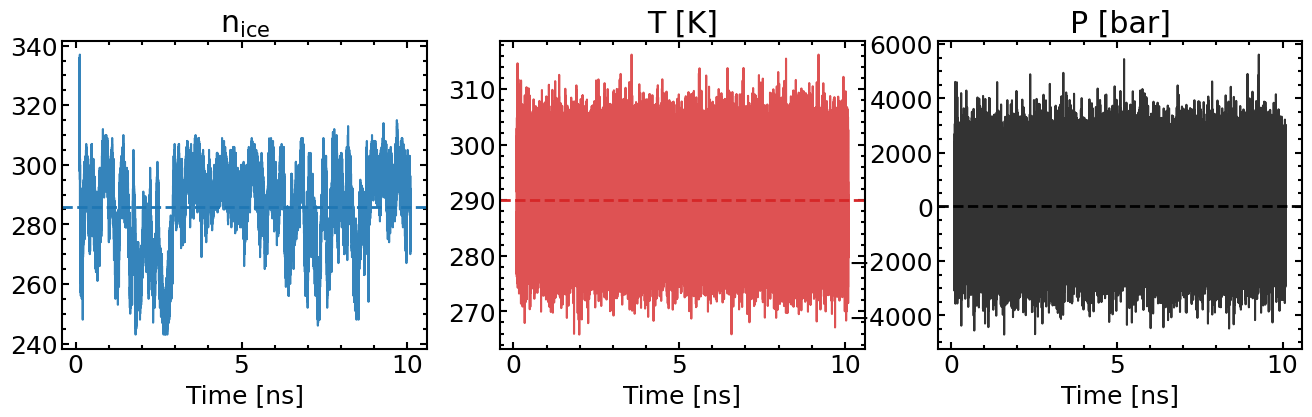

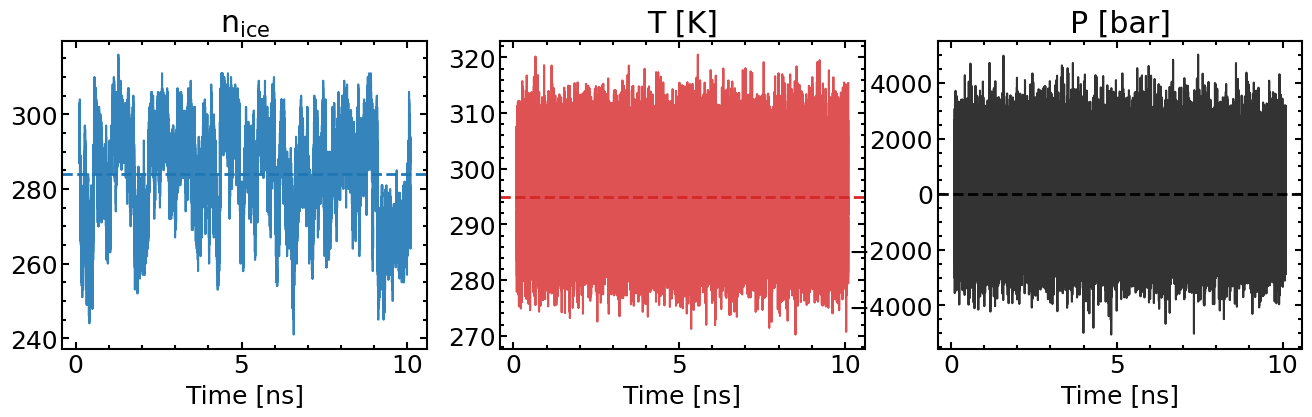

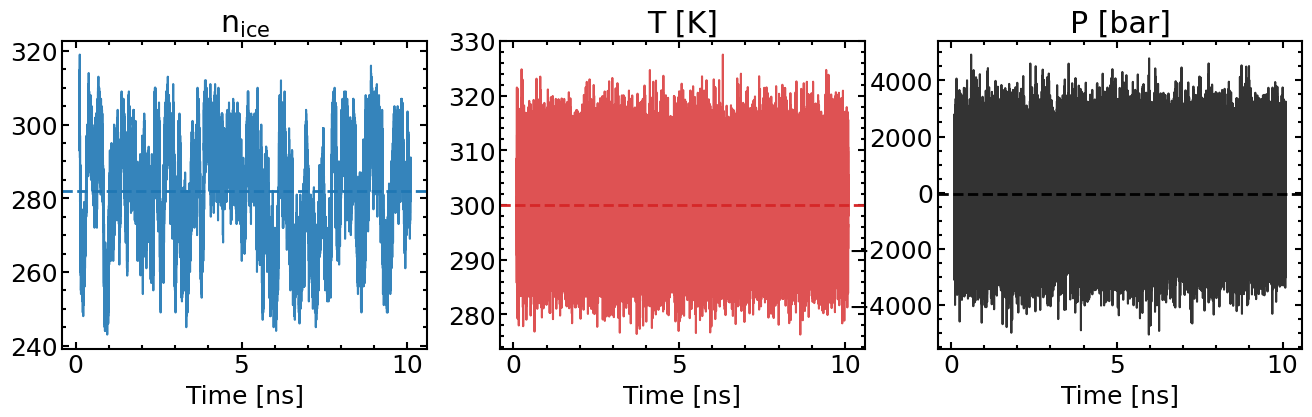

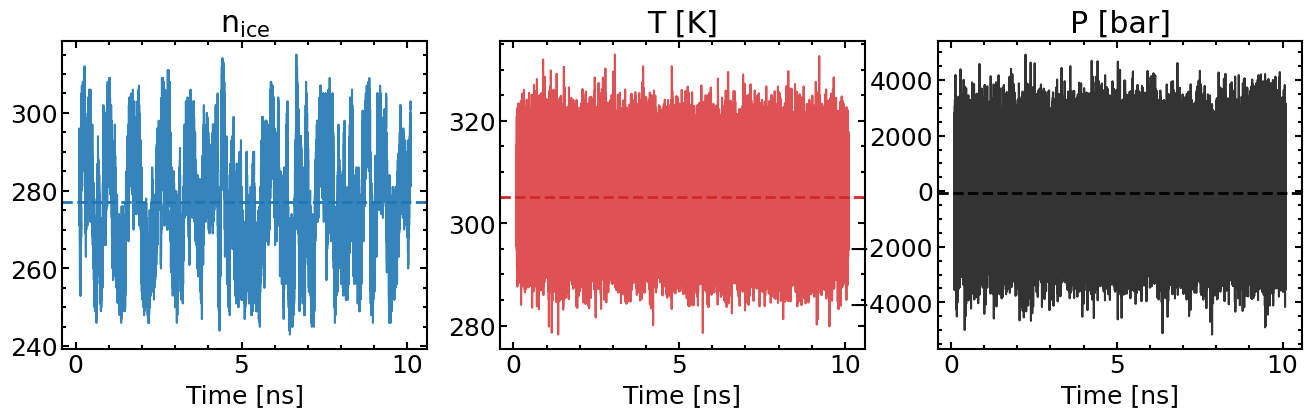

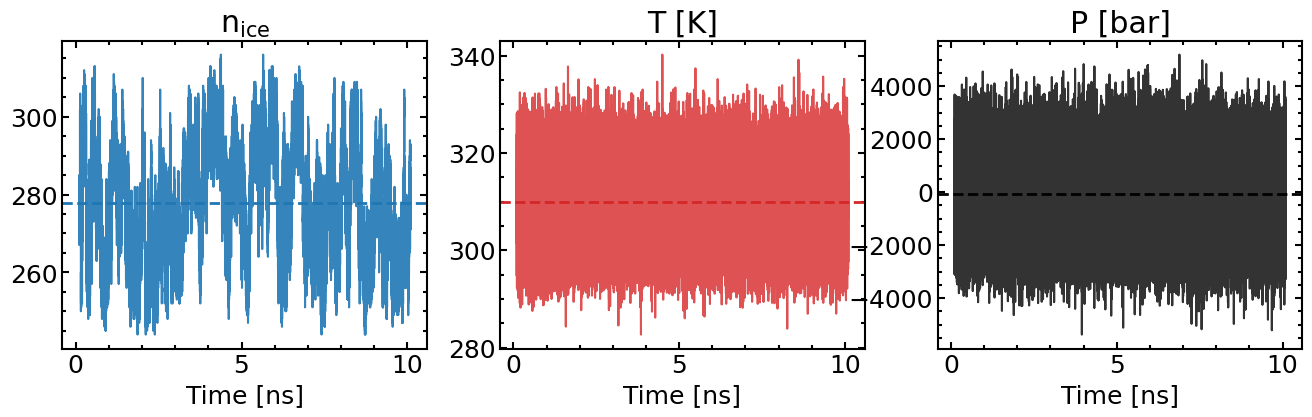

In [11]:
for T in np.linspace(290, 310, 5, dtype=int):
    plot_stats(f'../../full/ih/0_bar/2-coex/{T}')

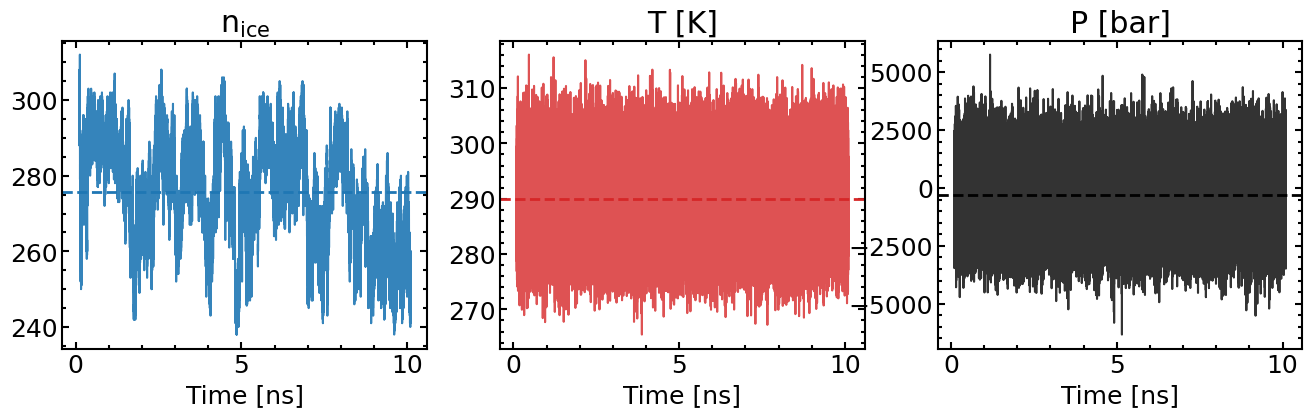

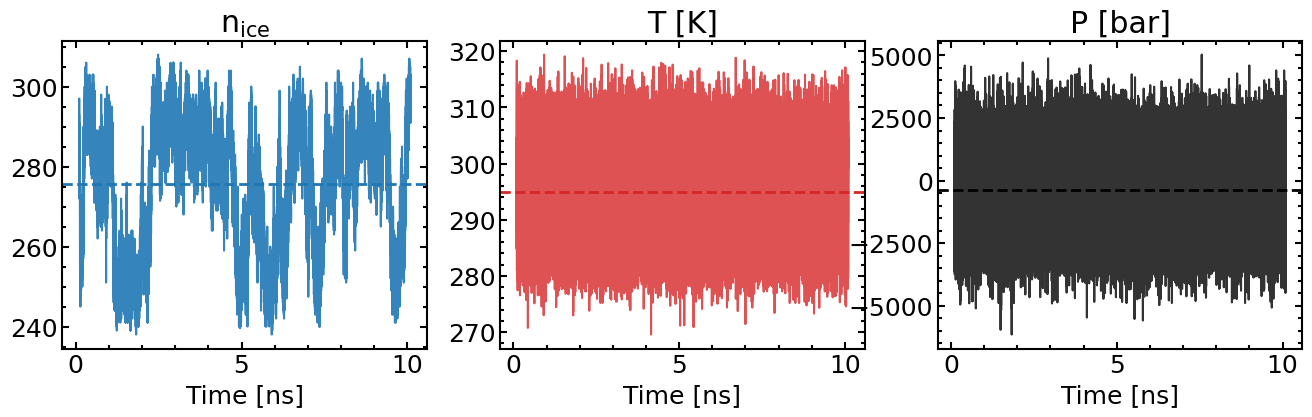

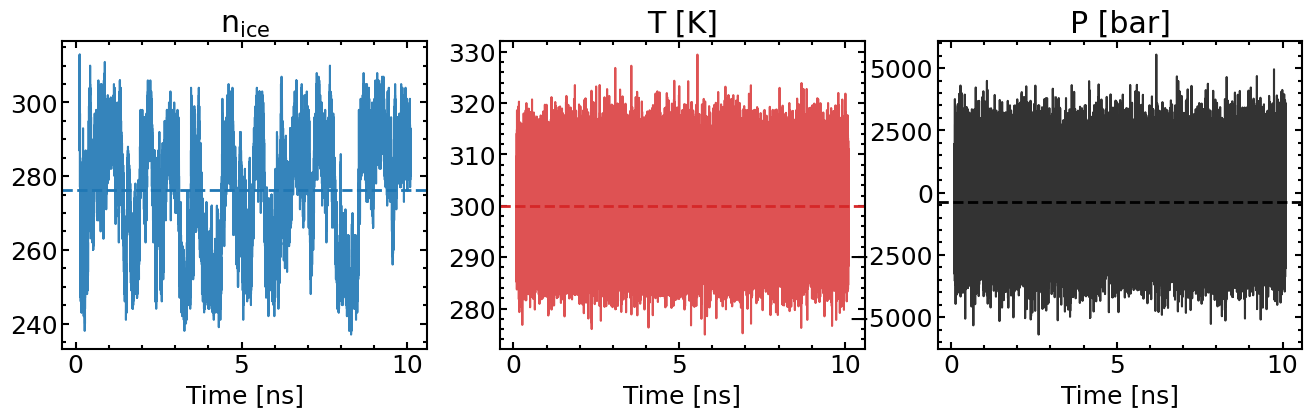

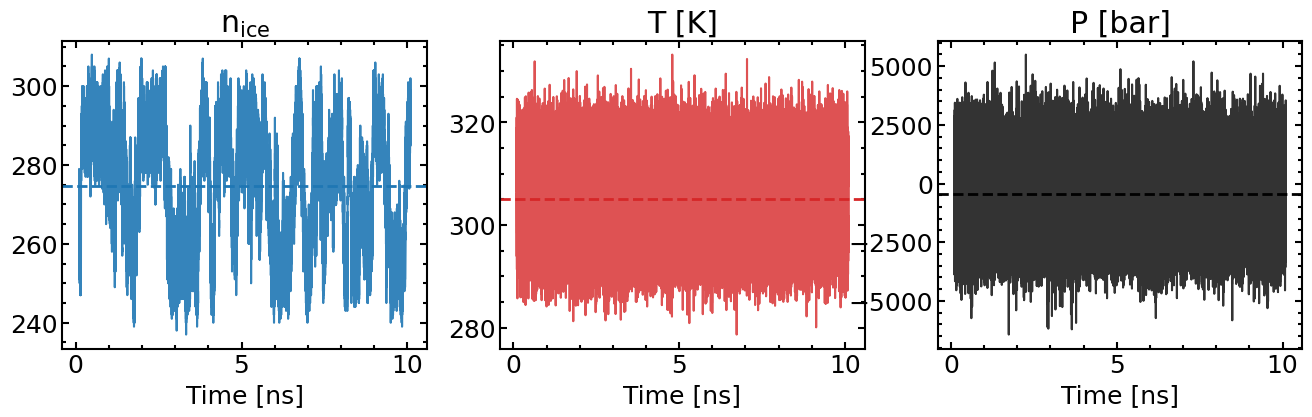

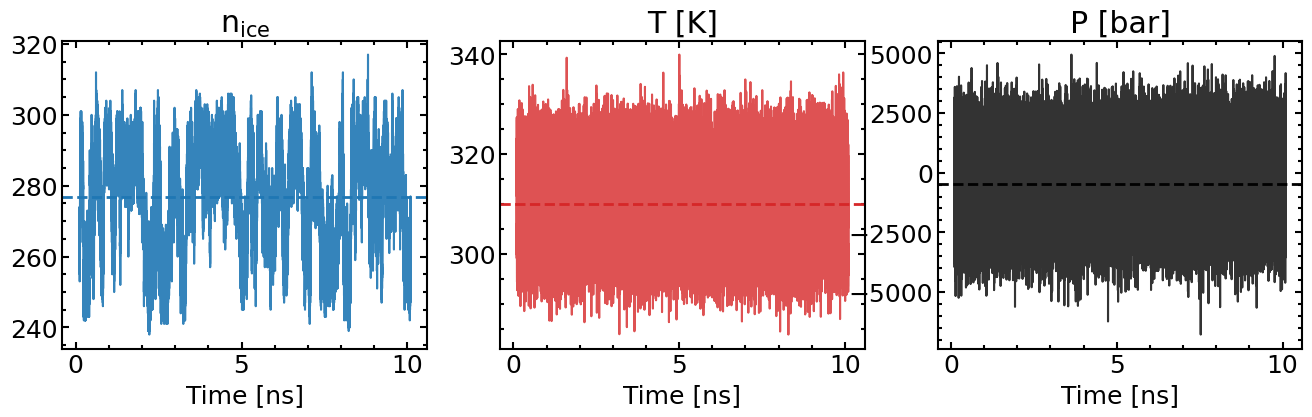

In [12]:
for T in np.linspace(290, 310, 5, dtype=int):
    plot_stats(f'../../full/ih/100_bar/2-coex/{T}')

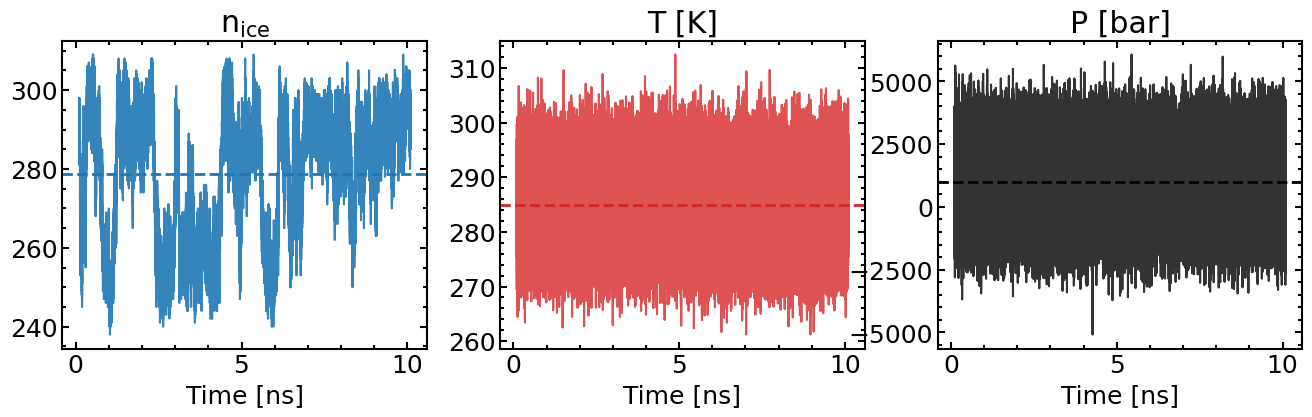

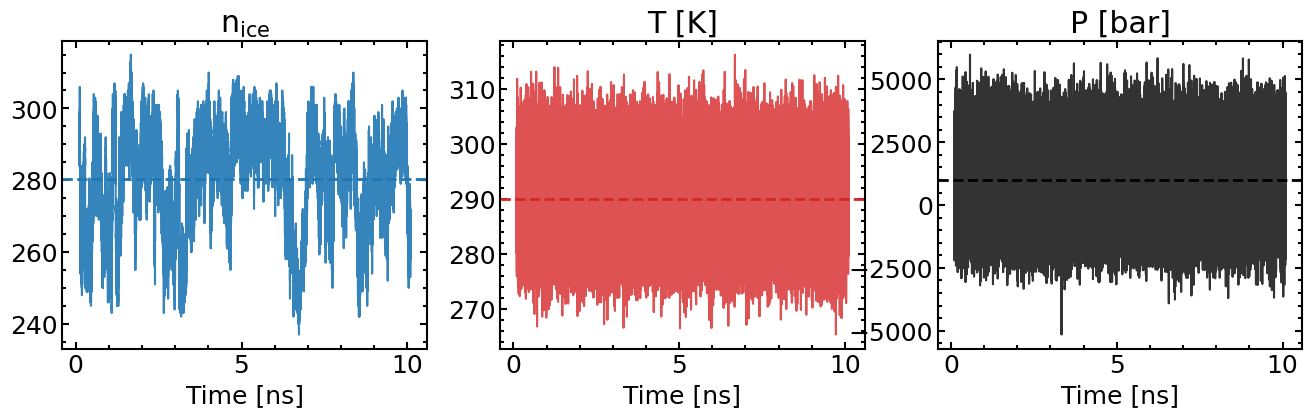

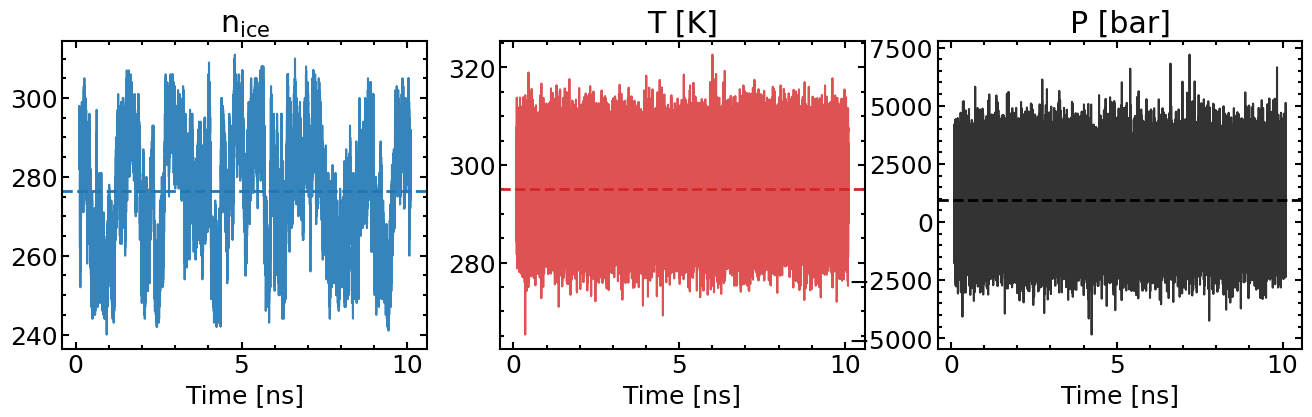

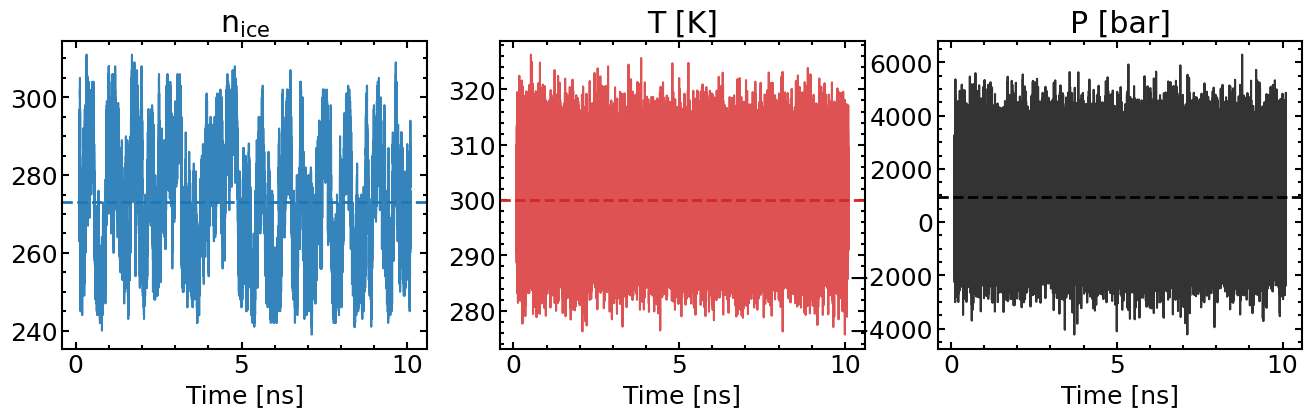

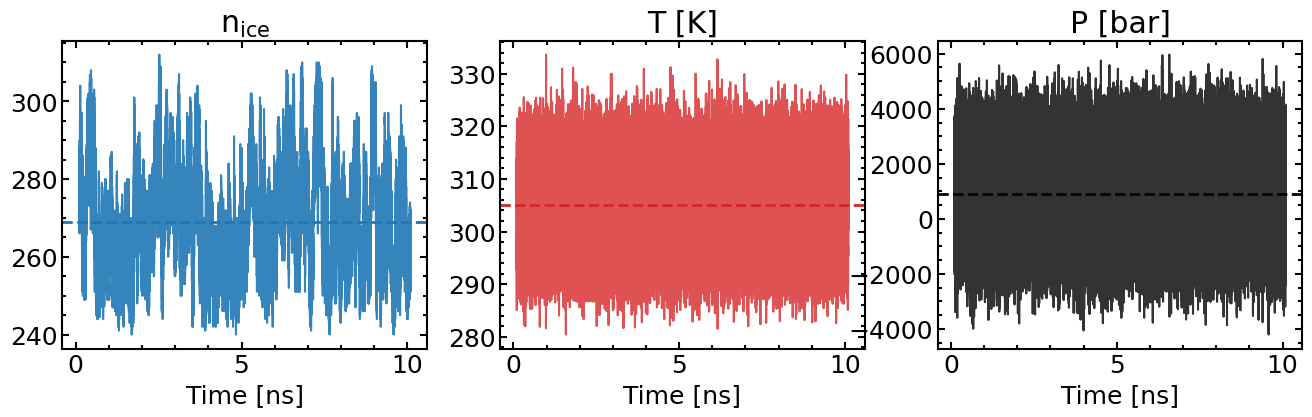

In [16]:
for T in np.linspace(285, 305, 5, dtype=int):
    plot_stats(f'../../full/ih/1000_bar/2-coex/{T}')

Text(0.5, 1.0, '$\\mathrm{V}$')

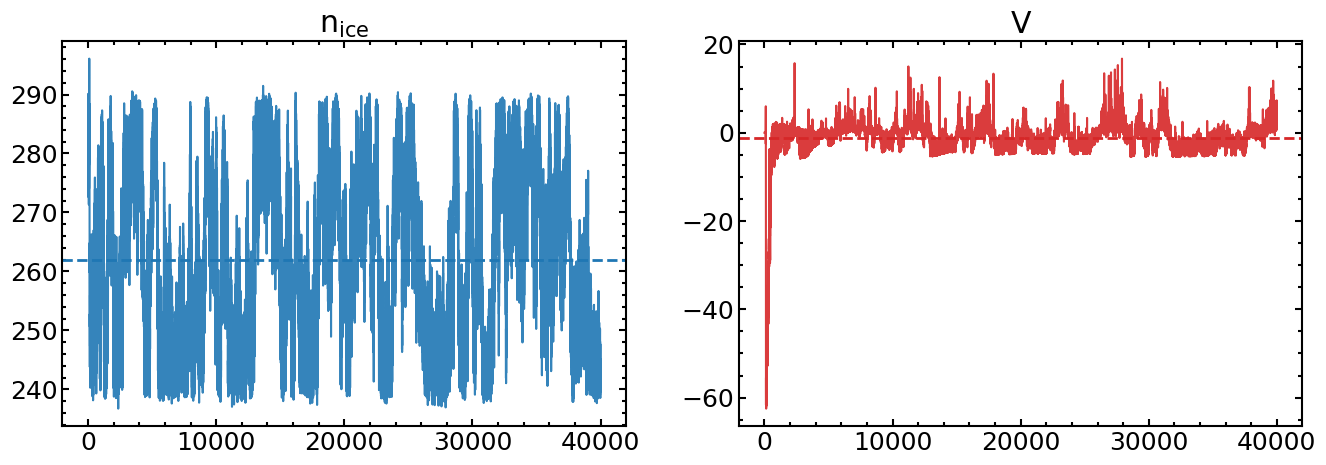

In [10]:
path = f'../full/2-coex/ih_0_bar/2-coex/{T}'
data = np.loadtxt(f'{path}/COLVAR')

n_ice = data[:,2]
b_pot = data[:,-3]

fig, ax = plt.subplots(figsize=(16,5), ncols=2)


ax[0].plot(n_ice, alpha=0.9, c='C0')
ax[0].axhline(np.average(n_ice), ls='--', color='C0', lw=2)
# ax[0].set_xlabel('Time [ps]')
# ax[0].set_ylabel('A $\mathrm{[\AA^{2}]}$')
ax[0].set_title('$\mathrm{n_{ice}}$')

ax[1].plot(b_pot, alpha=0.9, c='C3')
ax[1].axhline(np.average(b_pot), ls='--', color='C3', lw=2)
# ax[0].set_xlabel('Time [ps]')
# ax[0].set_ylabel('A $\mathrm{[\AA^{2}]}$')
ax[1].set_title('$\mathrm{V}$')

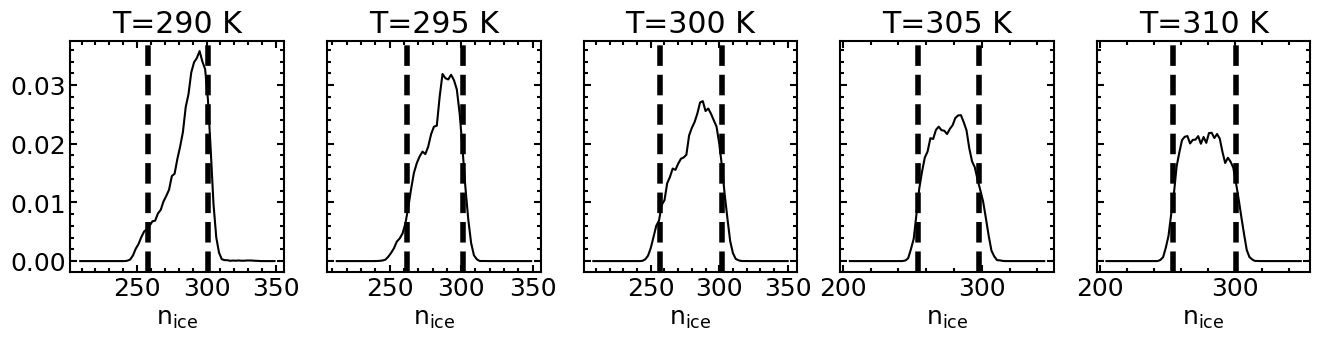

In [37]:
fig, ax = plt.subplots(figsize=(16,3), ncols=5, sharey=True)

for i, T in enumerate(range(290,311,5)):
    path = f'../../full/ih/0_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')

    dpl=0.05 # Lower probability range for strict histogram
    dph=0.05 # Upper probability range for strict histogram
    dh=2     # Bin size used for histogram
    NIGNORE_STANDARD=1500 # Ignore the first 1500 frames
    atm_to_gpa=0.000101325

    time_ns = data[:,0]/1E3
    number_of_ice  = data[:,-1]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]
    bins2=[i for i in range(ns-50,nf+50)]
    histo, bin_edges = np.histogram(number_of_ice,bins=bins2[::dh],density=True)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    ax[i].plot(n_ice_mid,histo,'-k')
    ax[i].axvline(x=ns,linewidth=4, color='k',ls='--')
    ax[i].axvline(x=nf,linewidth=4, color='k',ls='--')
    ax[i].set_title(f'T={T} K')
    ax[i].set_xlabel('$\mathrm{n_{ice}}$')

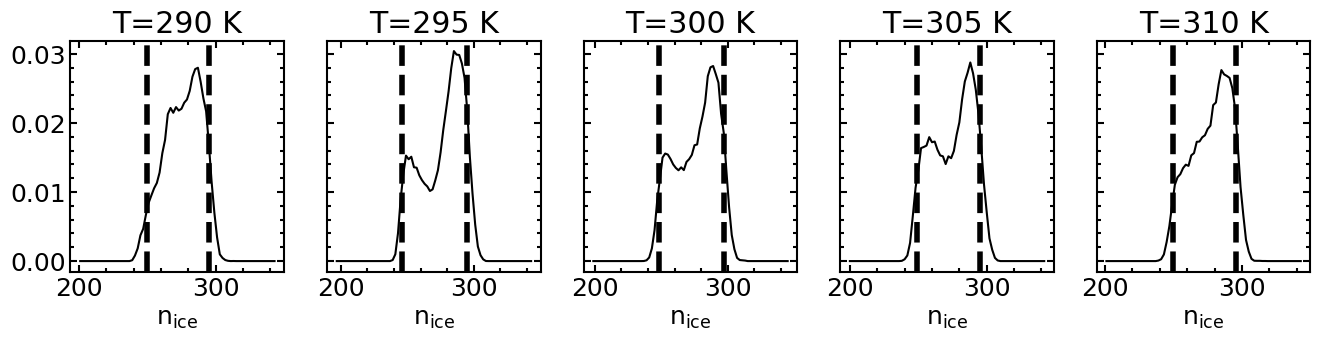

In [36]:
fig, ax = plt.subplots(figsize=(16,3), ncols=5, sharey=True)

for i, T in enumerate(range(290,311,5)):
    path = f'../../full/ih/100_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')

    dpl=0.05 # Lower probability range for strict histogram
    dph=0.05 # Upper probability range for strict histogram
    dh=2     # Bin size used for histogram
    NIGNORE_STANDARD=1500 # Ignore the first 1500 frames
    atm_to_gpa=0.000101325

    time_ns = data[:,0]/1E3
    number_of_ice  = data[:,-1]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]
    bins2=[i for i in range(ns-50,nf+50)]
    histo, bin_edges = np.histogram(number_of_ice,bins=bins2[::dh],density=True)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    ax[i].plot(n_ice_mid,histo,'-k')
    ax[i].axvline(x=ns,linewidth=4, color='k',ls='--')
    ax[i].axvline(x=nf,linewidth=4, color='k',ls='--')
    ax[i].set_title(f'T={T} K')
    ax[i].set_xlabel('$\mathrm{n_{ice}}$')

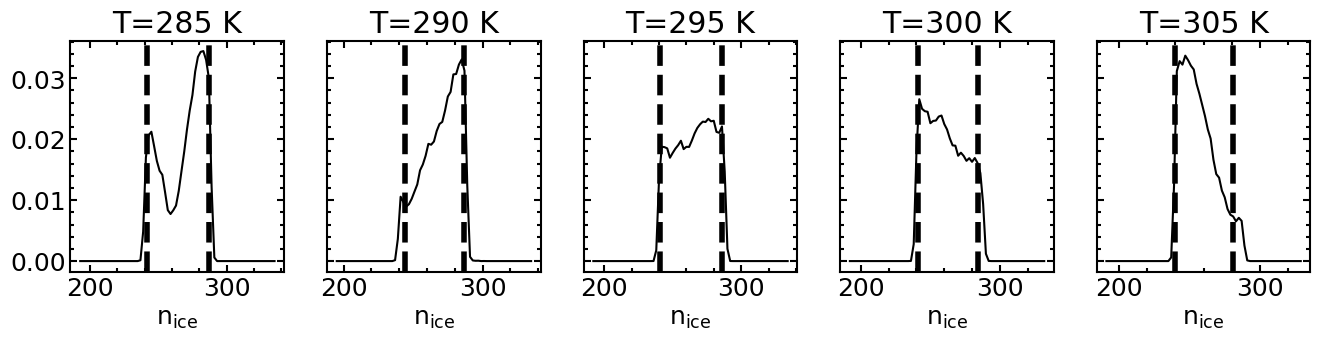

In [26]:
fig, ax = plt.subplots(figsize=(16,3), ncols=5, sharey=True)

for i, T in enumerate(range(285,306,5)):
    path = f'../../full/ih/1000_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')

    dpl=0.05 # Lower probability range for strict histogram
    dph=0.05 # Upper probability range for strict histogram
    dh=2     # Bin size used for histogram
    NIGNORE_STANDARD=1500 # Ignore the first 1500 frames
    atm_to_gpa=0.000101325

    time_ns = data[:,0]/1E3
    number_of_ice  = data[:,2]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]
    bins2=[i for i in range(ns-50,nf+50)]
    histo, bin_edges = np.histogram(number_of_ice,bins=bins2[::dh],density=True)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    ax[i].plot(n_ice_mid,histo,'-k')
    ax[i].axvline(x=ns,linewidth=4, color='k',ls='--')
    ax[i].axvline(x=nf,linewidth=4, color='k',ls='--')
    ax[i].set_title(f'T={T} K')
    ax[i].set_xlabel('$\mathrm{n_{ice}}$')

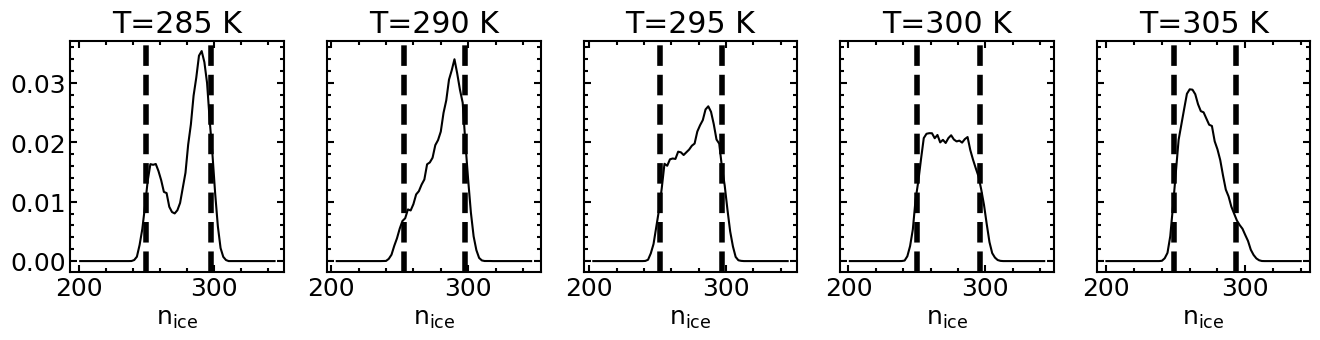

In [27]:
fig, ax = plt.subplots(figsize=(16,3), ncols=5, sharey=True)

for i, T in enumerate(range(285,306,5)):
    path = f'../../full/ih/1000_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')

    dpl=0.05 # Lower probability range for strict histogram
    dph=0.05 # Upper probability range for strict histogram
    dh=2     # Bin size used for histogram
    NIGNORE_STANDARD=1500 # Ignore the first 1500 frames
    atm_to_gpa=0.000101325

    time_ns = data[:,0]/1E3
    number_of_ice  = data[:,-1]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]
    bins2=[i for i in range(ns-50,nf+50)]
    histo, bin_edges = np.histogram(number_of_ice,bins=bins2[::dh],density=True)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    ax[i].plot(n_ice_mid,histo,'-k')
    ax[i].axvline(x=ns,linewidth=4, color='k',ls='--')
    ax[i].axvline(x=nf,linewidth=4, color='k',ls='--')
    ax[i].set_title(f'T={T} K')
    ax[i].set_xlabel('$\mathrm{n_{ice}}$')

Text(0, 0.5, '$\\Delta$G$_{\\mathrm{liq}\\to \\mathrm{ice}}$ (kJ mol$^{-1}$)')

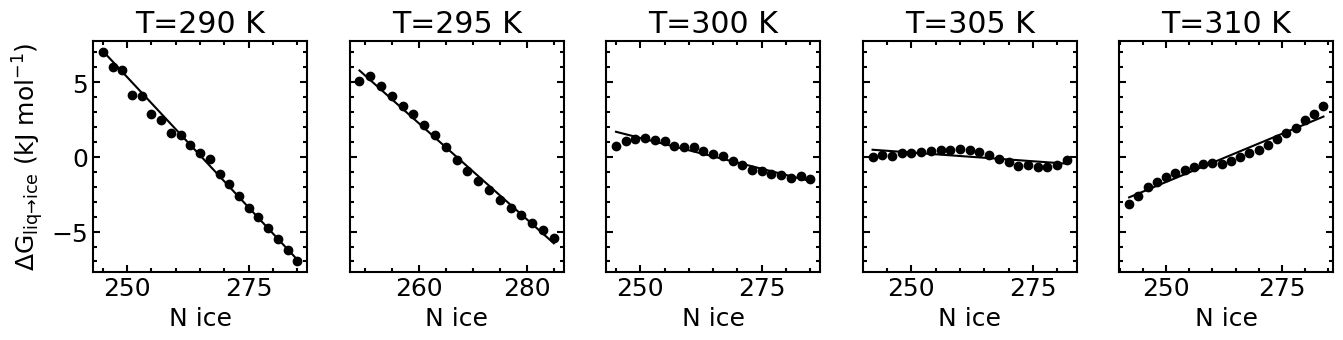

In [30]:
from scipy.optimize import curve_fit

def linear_fn(x, a, b):
    return a*x + b

fig, ax = plt.subplots(figsize=(16,3), ncols=5, sharey=True)

colors = plt.cm.viridis(np.linspace(0,1,5))
colors = ['k']*5
for i, T in enumerate(range(290,311,5)):
    path = f'../../full/ih/0_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')

    number_of_ice  = data[:,2]
    bias_potential = data[:,-3]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax(logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)

    fes_error = (1/beta)*histo_error/histo

    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error)

    n_water = bin_centers
    fes_linear = linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]

    ax[i].scatter(n_water,fes, c=colors[i])
    ax[i].plot(n_water,fes_linear, c=colors[i])
    ax[i].set_title(f'T={T} K')   
    ax[i].set_xlabel('N ice')
ax[0].set_ylabel(r'$\Delta$G$_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')

Text(0, 0.5, '$\\Delta$G$_{\\mathrm{liq}\\to \\mathrm{ice}}$ (kJ mol$^{-1}$)')

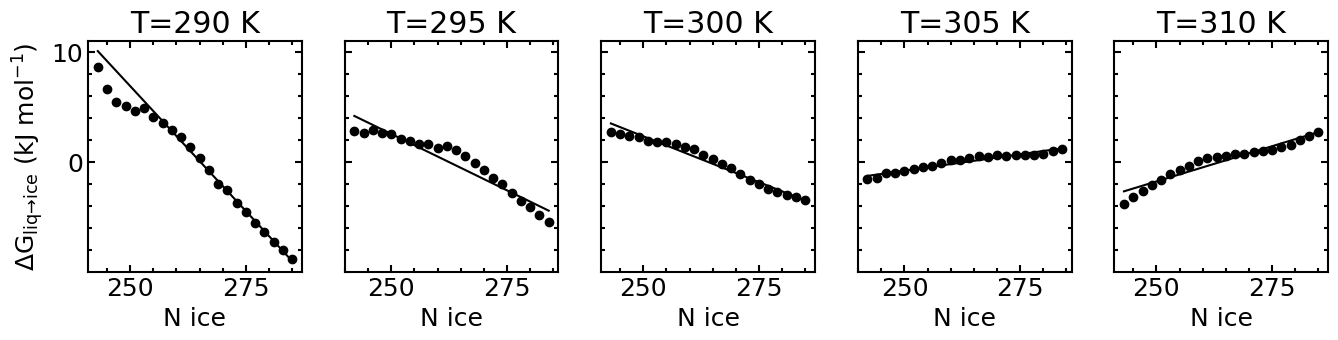

In [29]:
from scipy.optimize import curve_fit

def linear_fn(x, a, b):
    return a*x + b

fig, ax = plt.subplots(figsize=(16,3), ncols=5, sharey=True)

colors = plt.cm.viridis(np.linspace(0,1,5))
colors = ['k']*5
for i, T in enumerate(range(290,311,5)):
    path = f'../../full/ih/100_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')

    number_of_ice  = data[:,2]
    bias_potential = data[:,-3]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax(logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)

    fes_error = (1/beta)*histo_error/histo

    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error)

    n_water = bin_centers
    fes_linear = linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]

    ax[i].scatter(n_water,fes, c=colors[i])
    ax[i].plot(n_water,fes_linear, c=colors[i])
    ax[i].set_title(f'T={T} K')   
    ax[i].set_xlabel('N ice')
ax[0].set_ylabel(r'$\Delta$G$_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')

Text(0, 0.5, '$\\Delta$G$_{\\mathrm{liq}\\to \\mathrm{ice}}$ (kJ mol$^{-1}$)')

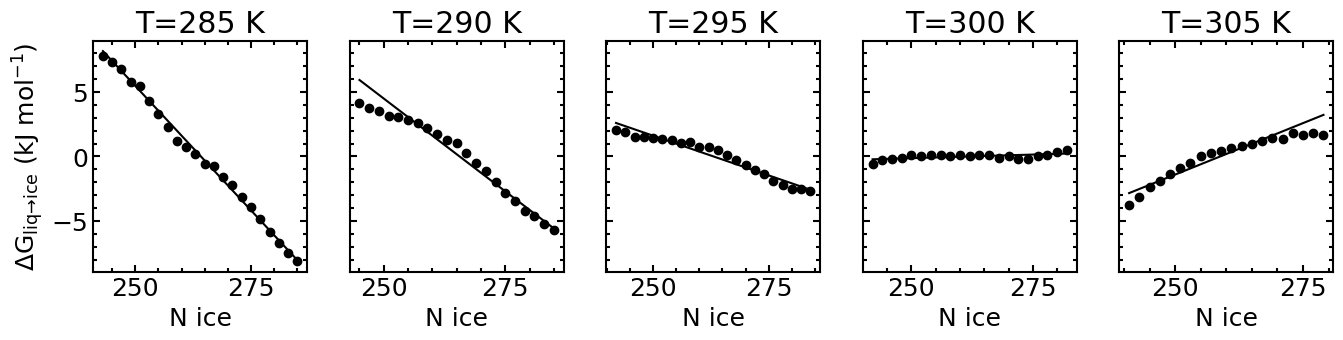

In [27]:
from scipy.optimize import curve_fit

def linear_fn(x, a, b):
    return a*x + b

fig, ax = plt.subplots(figsize=(16,3), ncols=5, sharey=True)

colors = plt.cm.viridis(np.linspace(0,1,5))
colors = ['k']*5
for i, T in enumerate(range(285,306,5)):
    path = f'../../full/ih/1000_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')

    number_of_ice  = data[:,2]
    bias_potential = data[:,-3]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax(logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)

    fes_error = (1/beta)*histo_error/histo

    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error)

    n_water = bin_centers
    fes_linear = linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]

    ax[i].scatter(n_water,fes, c=colors[i])
    ax[i].plot(n_water,fes_linear, c=colors[i])
    ax[i].set_title(f'T={T} K')   
    ax[i].set_xlabel('N ice')
ax[0].set_ylabel(r'$\Delta$G$_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')

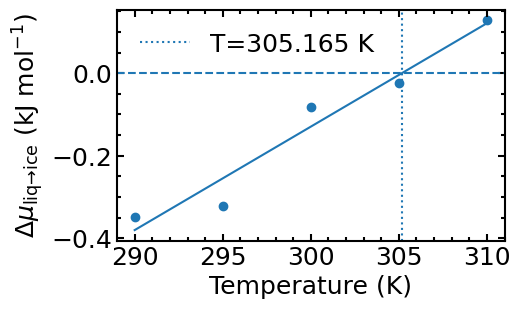

In [89]:
chem_pot_lst = np.zeros((5,3))
for i, T in enumerate(range(290,311,5)):
    path = f'../../full/ih/0_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')

    number_of_ice  = data[:,2]
    bias_potential = data[:,-3]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax(logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)

    fes_error = (1/beta)*histo_error/histo

    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error, maxfev=10)

    n_water = bin_centers
    fes_linear = linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]
    chem_pot_lst[i,0] = T
    chem_pot_lst[i,1] = popt[0]
    chem_pot_lst[i,2] = perr
    
    popt, pcov = curve_fit(linear_fn, chem_pot_lst[:,0], chem_pot_lst[:,1], maxfev=1000)


plt.figure(figsize=(5,3))
plt.scatter(chem_pot_lst[:,0],chem_pot_lst[:,1])
plt.plot(chem_pot_lst[:,0],linear_fn(chem_pot_lst[:,0],*popt))
plt.axhline(0, ls='--')
plt.axvline(-popt[1]/popt[0], ls=':', label=f'T={np.round(-popt[1]/popt[0],3)} K')
plt.ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')
plt.xlabel('Temperature (K)')    
plt.legend(frameon=False)

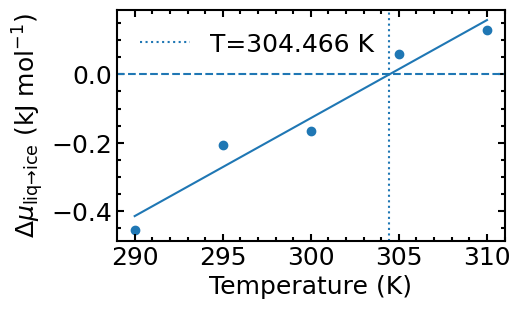

In [85]:
chem_pot_lst = np.zeros((5,3))
for i, T in enumerate(range(290,311,5)):
    path = f'../../full/ih/100_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')

    number_of_ice  = data[:,2]
    bias_potential = data[:,-3]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax(logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)

    fes_error = (1/beta)*histo_error/histo

    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error, maxfev=10)

    n_water = bin_centers
    fes_linear = linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]
    chem_pot_lst[i,0] = T
    chem_pot_lst[i,1] = popt[0]
    chem_pot_lst[i,2] = perr
    
    popt, pcov = curve_fit(linear_fn, chem_pot_lst[:,0], chem_pot_lst[:,1], maxfev=1000)


plt.figure(figsize=(5,3))
plt.scatter(chem_pot_lst[:,0],chem_pot_lst[:,1])
plt.plot(chem_pot_lst[:,0],linear_fn(chem_pot_lst[:,0],*popt))
plt.axhline(0, ls='--')
plt.axvline(-popt[1]/popt[0], ls=':', label=f'T={np.round(-popt[1]/popt[0],3)} K')
plt.ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')
plt.xlabel('Temperature (K)')    
plt.legend(frameon=False)

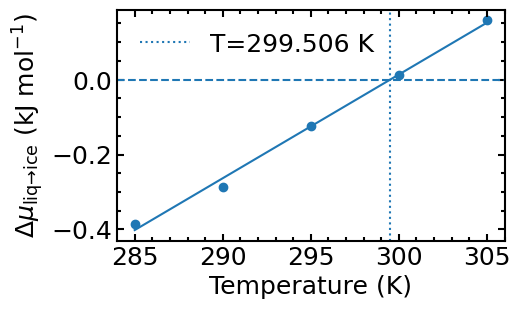

In [86]:
chem_pot_lst = np.zeros((5,3))
for i, T in enumerate(range(285,306,5)):
    path = f'../../full/ih/1000_bar/2-coex/{T}'
    data = np.loadtxt(f'{path}/COLVAR')

    number_of_ice  = data[:,2]
    bias_potential = data[:,-3]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax(logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)

    fes_error = (1/beta)*histo_error/histo

    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error, maxfev=10)

    n_water = bin_centers
    fes_linear = linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]
    chem_pot_lst[i,0] = T
    chem_pot_lst[i,1] = popt[0]
    chem_pot_lst[i,2] = perr
    
    popt, pcov = curve_fit(linear_fn, chem_pot_lst[:,0], chem_pot_lst[:,1], maxfev=1000)


plt.figure(figsize=(5,3))
plt.scatter(chem_pot_lst[:,0],chem_pot_lst[:,1])
plt.plot(chem_pot_lst[:,0],linear_fn(chem_pot_lst[:,0],*popt))
plt.axhline(0, ls='--')
plt.axvline(-popt[1]/popt[0], ls=':', label=f'T={np.round(-popt[1]/popt[0],3)} K')
plt.ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')
plt.xlabel('Temperature (K)')    
plt.legend(frameon=False)

Text(0, 0.5, 'ns/day')

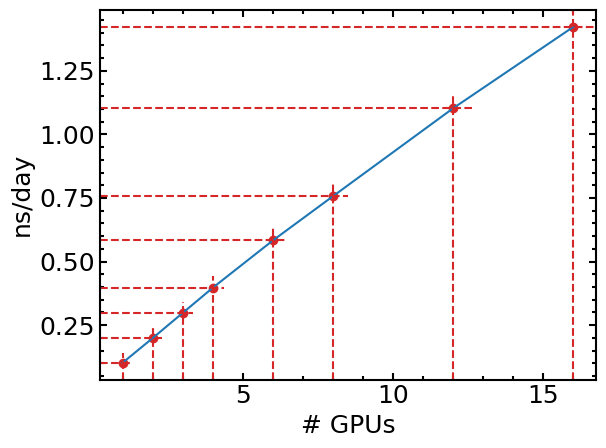

In [95]:
g = [1,2,3,4,6,8,12,16]
t = [0.102,0.199,0.298,0.397,0.583,0.757,1.103,1.423]

plt.plot(g,t,'-')
plt.scatter(g,t,c='C3')

for i in range(len(g)):
    plt.axhline(t[i], xmax=g[i]/g[-1], ls='--', c='C3')
    plt.axvline(g[i], ymax=t[i]/t[-1], ls='--', c='C3')
plt.xlabel('# GPUs')
plt.ylabel('ns/day')

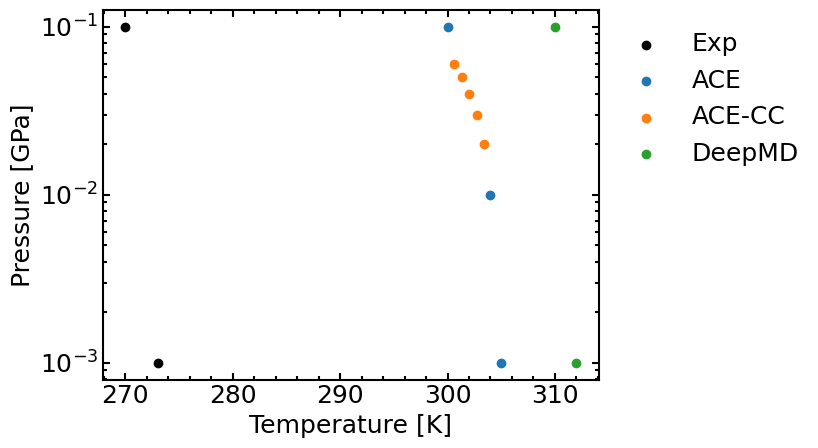

In [45]:
plt.scatter([273,270], [0.001,0.1], label='Exp', c='k')
plt.scatter([305,304,300], [0.001,0.01,0.1], label='ACE')
plt.scatter([303.3575932303014,
 302.70471130137065,
 302.0226029314052,
 301.332751880464,
 300.62931927726555],
            [0.02,0.03, 0.04, 0.05, 0.06], label='ACE-CC')
plt.scatter([312,310], [0.001,0.1], label='DeepMD')
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [GPa]')
plt.yscale('log')
plt.legend(frameon=0, bbox_to_anchor=(1,1))

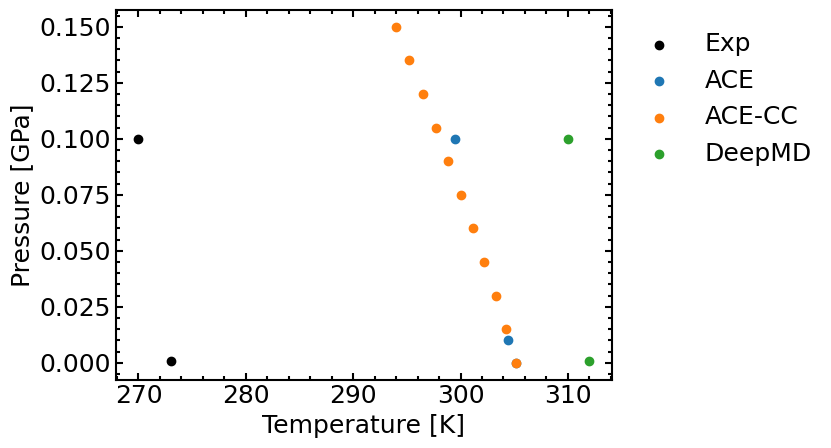

In [97]:
plt.scatter([273,270], [0.001,0.1], label='Exp', c='k')
plt.scatter([305.165,304.466,299.506], [0.00,0.01,0.1], label='ACE')
# plt.scatter([303.3599659509678,
#  302.6991561949917,
#  302.0190522721374,
#  301.31860489861646,
#  300.5980572438026]
# ,
#             [0.02,0.03, 0.04, 0.05, 0.06], label='ACE-CC-1ns', marker='o')
plt.scatter([305.165,
 304.23321247181025,
 303.2613636650872,
 302.1909771986023,
 301.11920144225945,
 299.99720799014756,
 298.8509170825427,
 297.6831555087371,
 296.476610258458,
 295.2304690708246,
 293.94238145173904],
            np.array([0, 150, 300, 450, 600, 750, 900, 1050, 1200, 1350, 1500])*1e-4,
                     label='ACE-CC', marker='o')
plt.scatter([312,310], [0.001,0.1], label='DeepMD')
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [GPa]')
# plt.yscale('log')
plt.legend(frameon=0, bbox_to_anchor=(1,1))

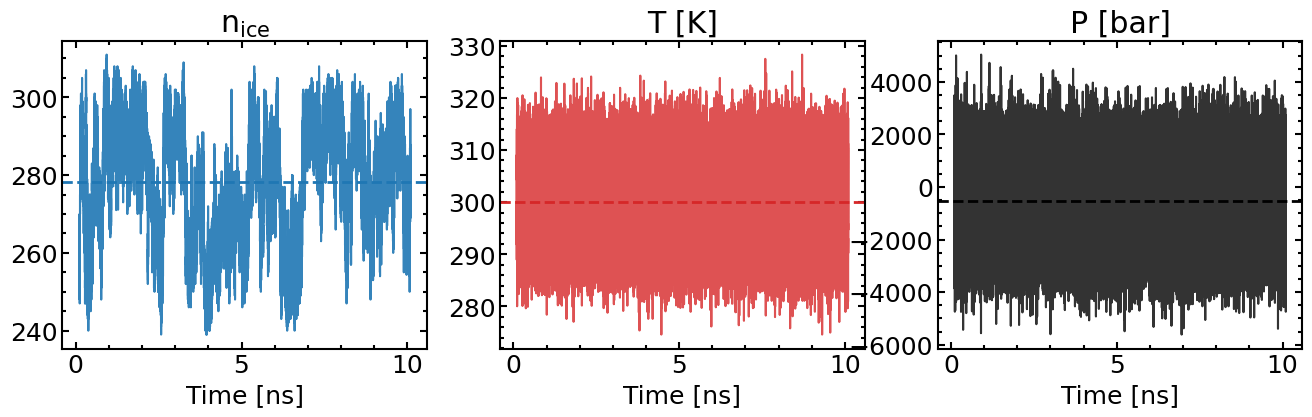

In [15]:
plot_stats(f'../../full/ih/test/300/')

Text(0, 0.5, '$\\Delta$G$_{\\mathrm{liq}\\to \\mathrm{ice}}$ (kJ mol$^{-1}$)')

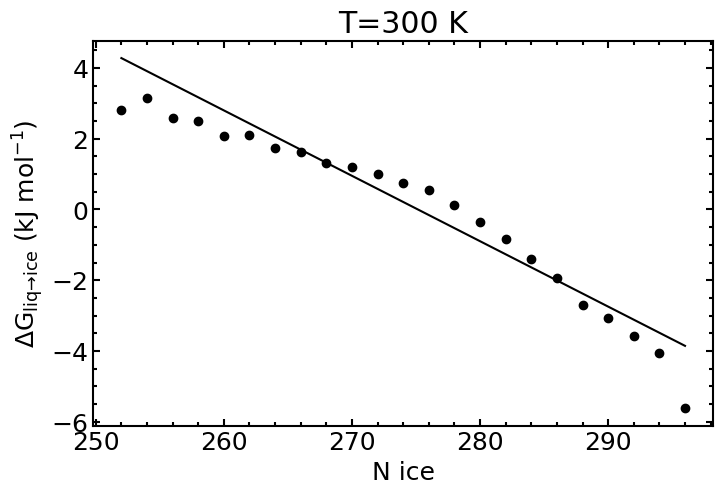

In [25]:
from scipy.optimize import curve_fit

def linear_fn(x, a, b):
    return a*x + b

fig, ax = plt.subplots(figsize=(8,5), ncols=1, sharey=True)

colors = plt.cm.viridis(np.linspace(0,1,1))
colors = ['k']*5
for i, T in enumerate(range(300,301,1)):
    path = f'../../full/ih/test/300/'
    data = pd.read_csv(f'{path}/COLVAR',sep= '\s+')
    data.columns = np.roll(data.columns,-2)

    dpl=0.05 # Lower probability range for strict histogram
    dph=0.05 # Upper probability range for strict histogram
    dh=2     # Bin size used for histogram
    NIGNORE_STANDARD=1500 # Ignore the first 1500 frames
    atm_to_gpa=0.000101325
    
    number_of_ice  = data['refcv2.morethan'][ign:]
    bias_potential = data['opes.bias'][ign:]

    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax(logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)

    fes_error = (1/beta)*histo_error/histo

    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error)

    n_water = bin_centers
    fes_linear = linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]

    ax.scatter(n_water,fes, c=colors[i])
    ax.plot(n_water,fes_linear, c=colors[i])
    ax.set_title(f'T={T} K')   
    ax.set_xlabel('N ice')
ax.set_ylabel(r'$\Delta$G$_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')